# Portfolio Optimization Using the Black-Litterman Model vs. Markowitz

This project showcases portfolio optimization using historical data of selected US tech stocks. It compares the traditional **Tangency Portfolio** (derived from the Markowitz Efficient Frontier) with the **Black-Litterman (BL)** approach, including cases:
- With **subjective investor views** (expressed as expected returns for selected stocks),
- And with **"zero views"** (i.e., neutral – consistent with the market equilibrium).

The project demonstrates:
- Understanding of the mechanics behind Black-Litterman blending market equilibrium with investor beliefs,
- Ability to construct BL portfolios with and without subjective views,
- Computing implied returns, risks, and optimal portfolio weights using real financial data.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import scipy.optimize as spop

In [2]:
# Load Historical Data
# Define list of stock tickers
tickers = ['AAPL', 'MSFT', 'GOOGL', 'NVDA', 'TSLA', 'META']

# Download historical closing price data (last 10 years)
data = yf.download(tickers, start='2015-05-01', end='2025-05-01')['Close']
data.index.name = None
data=data[tickers]
# Calculate daily returns
returns_df = data.pct_change().dropna()
data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  6 of 6 completed


Ticker,AAPL,MSFT,GOOGL,NVDA,TSLA,META
2015-05-01,28.798103,41.997147,27.426874,0.548079,15.068667,78.619469
2015-05-04,28.742270,41.634663,27.510475,0.544706,15.367333,78.440315
2015-05-05,28.094618,41.082302,27.022804,0.530733,15.530000,77.196175
2015-05-06,27.918188,39.943035,26.626698,0.532419,15.362000,77.733643
2015-05-07,28.090876,40.305523,26.973042,0.541815,15.786667,78.062088
...,...,...,...,...,...,...
2025-04-24,208.369995,387.299988,159.279999,106.430000,259.510010,533.150024
2025-04-25,209.279999,391.850006,161.960007,111.010002,284.950012,547.270020
2025-04-28,210.139999,391.160004,160.610001,108.730003,285.880005,549.739990
2025-04-29,211.210007,394.040009,160.160004,109.019997,292.029999,554.440002


# Define Market Capitalization Weights

After downloading historical price data (which allows us to compute historical return correlations and volatilities), we define the market capitalization-based portfolio weights. These weights (`w_mkt`) represent the proportion of each asset in the market portfolio, commonly used in the Black-Litterman model to derive implied equilibrium returns (π). This market portfolio reflects the "aggregate investor" consensus.


In [3]:
w_mkt=np.array([0.26197975, 0.25998147, 0.07719071, 0.22392396, 0.07429452, 0.10262958])
w_mkt

array([0.26197975, 0.25998147, 0.07719071, 0.22392396, 0.07429452,
       0.10262958])

In [4]:
#calculating the return vector and the covariance matrix
cov = returns_df.cov() * 252
r = np.array(((1 + returns_df).prod())**(252 / len(returns_df)) - 1)
e = np.ones(len(r))
r

# Compute Matrix Constants for Frontier
icov = np.linalg.inv(cov)
h = np.matmul(e, icov)
g = np.matmul(r, icov)
a = np.sum(e * h)
b = np.sum(e * g)
c = np.sum(r * g)
d = a * c - b**2

### Define Investor Views: Matrices `P` and `Q`

In the Black-Litterman model, investor beliefs are encoded using two components:

- `P`: the **pick matrix** that selects which assets the views refer to,
- `Q`: the **expected returns** for those assets, reflecting the investor's subjective expectations.

In this example:
- The investor expects **Tesla** to deliver a **+2%** return,
- **Nvidia** to underperform with a **–9%** return,
- **Apple** to strongly outperform with a **+10%** return.

These views are purely illustrative but demonstrate how specific return expectations can be embedded into the model. In practice, such views might be informed by **fundamental research** (e.g., financial ratios, earnings forecasts), **technical analysis** (e.g., price patterns or momentum), or even **informational signals** (e.g., alternative data, sentiment analysis). This flexibility makes Black-Litterman a powerful framework for blending quantitative market structure with qualitative conviction.


In [5]:
P = np.array([
    [0, 0, 0, 0, 1, 0],   # Tesla
    [0, 0, 0, 1, 0, 0],   # Nvidia
    [1, 0, 0, 0, 0, 0],   # Apple
])

Q = np.array([0.02, -0.09, 0.1])  # personal views about expected returns


In [6]:
# lambda: risk aversion coefficient
market_var = w_mkt.T @ cov @ w_mkt
exp_market_return = r @ w_mkt
lmbda = exp_market_return / market_var

# implied equilibrium returns (pi)
pi = lmbda * cov @ w_mkt

# omega: uncertainty of views (diagonal, simplest assumption)
tau = 0.05
omega = np.diag(np.diag(P @ (tau * cov) @ P.T))

# Black-Litterman expected returns
tau_cov_inv = np.linalg.inv(tau * cov)
omega_inv = np.linalg.inv(omega)
middle = np.linalg.inv(tau_cov_inv + P.T @ omega_inv @ P)
mu_bl = middle @ (tau_cov_inv @ pi + P.T @ omega_inv @ Q)

# New weights
w_bl = np.linalg.inv(lmbda * cov) @ mu_bl
w_bl = w_bl / np.sum(w_bl)

bl_weights = pd.Series(w_bl, index=tickers)
print(bl_weights)


AAPL     0.272210
MSFT     0.472447
GOOGL    0.140274
NVDA    -0.050923
TSLA    -0.020510
META     0.186502
dtype: float64


### Additional Investor Views

After obtaining portfolio weights based on the previous investor views, we now introduce an alternative set of subjective beliefs to compare their impact on the final asset allocation.

These views can be interpreted as follows:
- **Apple (AAPL)** is expected to deliver a **10%** annual return.
- **Meta (META)** is expected to perform **5% worse** than current expectations, i.e., a **−5%** annual return.
- **Nvidia (NVDA)** is also expected to return **−5%** annually.
- **Google (GOOGL)** is anticipated to perform very strongly, with an expected annual return of **18%**.

In [7]:
# Another investor Views
P_new = np.array([
    [1, 0, 0, 0, 0, 0],   # Apple
    [0, 0, 1, 0, 0, 0],   # Meta
    [0, 0, 0, 1, 0, 0],   # Nvidia
    [0, 1, 0, 0, 0, 0],   # Google
])

Q_new = np.array([0.1, -0.05, -0.05, 0.18])  # Another personal views

omega_new = np.diag(np.diag(P_new @ (tau * cov) @ P_new.T))

tau_cov_inv = np.linalg.inv(tau * cov)
omega_inv = np.linalg.inv(omega_new)
middle = np.linalg.inv(tau_cov_inv + P_new.T @ omega_inv @ P_new)
mu_bl_new = middle @ (tau_cov_inv @ pi + P_new.T @ omega_inv @ Q_new)

# Another weights
w_bl_new = np.linalg.inv(lmbda * cov) @ mu_bl_new
w_bl_new /= np.sum(w_bl_new)

pd.Series(w_bl_new, index=tickers)


AAPL     0.362846
MSFT     0.897111
GOOGL   -0.655906
NVDA     0.005362
TSLA     0.164016
META     0.226570
dtype: float64

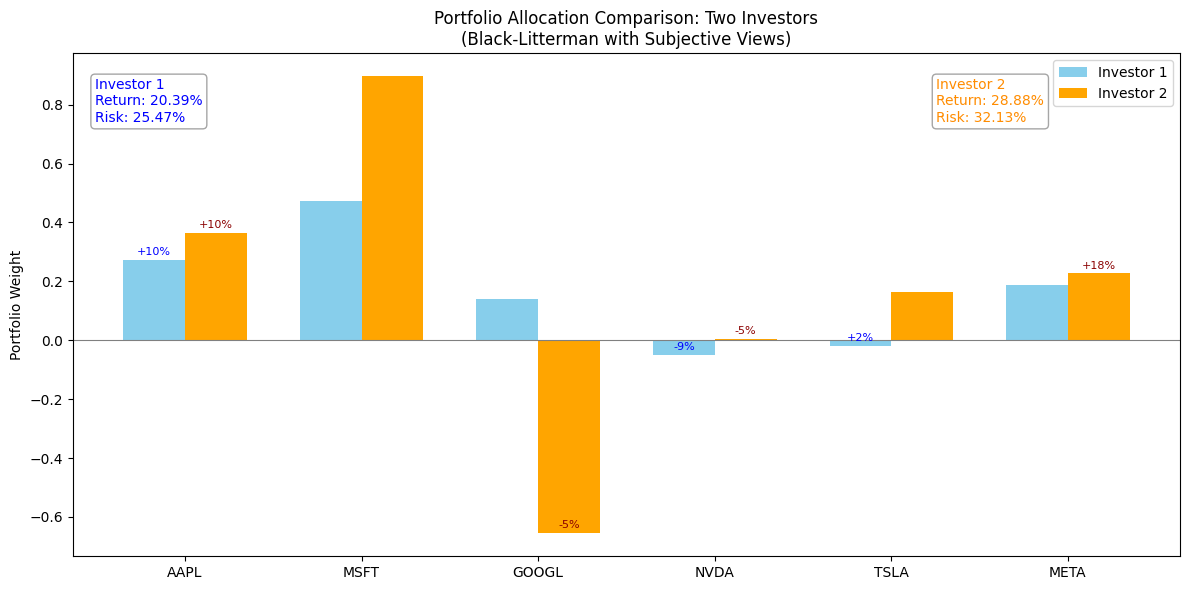

In [8]:
x = np.arange(len(tickers))
width = 0.35

# Black-Litterman portfolio weights for both investors
weights1 = np.array(bl_weights)
weights2 = np.array(w_bl_new)

# Views (expected excess returns)
views1 = {'AAPL': 0.10, 'NVDA': -0.09, 'TSLA': 0.02}
views2 = {'AAPL': 0.10, 'GOOGL': -0.05, 'NVDA': -0.05, 'META': 0.18}

# Compute expected return and risk for each investor
expected_return1 = np.dot(weights1, r)
risk1 = np.sqrt(weights1.T @ cov @ weights1)

expected_return2 = np.dot(weights2, r)
risk2 = np.sqrt(weights2.T @ cov @ weights2)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, weights1, width, label='Investor 1', color='skyblue')
bars2 = ax.bar(x + width/2, weights2, width, label='Investor 2', color='orange')

# Annotate views above bars
for i, ticker in enumerate(tickers):
    if ticker in views1:
        ax.text(x[i] - width/2, weights1[i] + 0.01,
                f'{views1[ticker]:+.0%}', ha='center', va='bottom', fontsize=8, color='blue')
    if ticker in views2:
        ax.text(x[i] + width/2, weights2[i] + 0.01,
                f'{views2[ticker]:+.0%}', ha='center', va='bottom', fontsize=8, color='darkred')

# Annotate expected return and risk in corners
box_style = dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='gray')
ax.text(0.02, 0.95, f"Investor 1\nReturn: {expected_return1:.2%}\nRisk: {risk1:.2%}",
        transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=box_style, color='blue')

ax.text(0.78, 0.95, f"Investor 2\nReturn: {expected_return2:.2%}\nRisk: {risk2:.2%}",
        transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=box_style, color='darkorange')

# Labels and styling
ax.set_ylabel('Portfolio Weight')
ax.set_title('Portfolio Allocation Comparison: Two Investors\n(Black-Litterman with Subjective Views)')
ax.set_xticks(x)
ax.set_xticklabels(tickers)
ax.legend()
ax.axhline(0, color='gray', linewidth=0.8)
plt.tight_layout()
plt.show()

### Portfolio Allocation Comparison: Two Investors

The chart illustrates the portfolio weights for six assets (AAPL, MSFT, GOOGL, NVDA, TSLA, META) derived using the Black-Litterman model based on two different sets of investor views:

### Key Observations:

MSFT (Microsoft): Investor 2 allocates a very large share (~90%), possibly due to lack of negative views and confidence in other positions.

GOOGL (Google): Investor 2 strongly underweights it (negative weight), aligned with the −5% view.

AAPL (Apple): Both investors express a +10% view, but portfolio weights differ due to the influence of their other views, which shift capital  allocation differently.

TSLA (Tesla): Only Investor 1 explicitly states a +2% view, but Investor 2 allocates a higher weight. This likely reflects that +2% is below Tesla’s implied return, leading the model to reduce its weight in Investor 1’s portfolio.
    
### Performance Metrics:

Investor 2’s portfolio has higher expected return (28.88%), but also significantly higher risk (32.13%).

Investor 1’s portfolio is more balanced, with lower return (20.39%) and lower risk (25.47%).

### Conclusion:

The chart clearly shows how different subjective views — whether conservative or aggressive — directly shape portfolio allocation and its resulting risk/return profile. The Black-Litterman model effectively integrates these beliefs, allowing for flexible and personalized investment strategies.

## Sensitivity Analysis of Portfolio Allocation – Similar Views

This section presents a sensitivity analysis of portfolio allocations under two slightly different sets of investment views. The goal is to examine how minor changes in assumptions affect the final portfolio structure and performance metrics (return and risk). This helps assess the robustness of the optimization process and the stability of portfolio construction in the presence of small variations in investor outlook.


In [9]:
# Another investor Views
P_new2 = np.array([
    [1, 0, 0, 0, 0, 0],   # Apple
    [0, 0, 1, 0, 0, 0],   # Meta
    [0, 0, 0, 1, 0, 0],   # Nvidia
    [0, 1, 0, 0, 0, 0],   # Google
])

Q_new2 = np.array([0.12, -0.03, -0.03, 0.20])  # Another expected returns

omega_new2 = np.diag(np.diag(P_new2 @ (tau * cov) @ P_new2.T))

tau_cov_inv = np.linalg.inv(tau * cov)
omega_inv2 = np.linalg.inv(omega_new2)
middle2 = np.linalg.inv(tau_cov_inv + P_new2.T @ omega_inv2 @ P_new2)
mu_bl_new2 = middle2 @ (tau_cov_inv @ pi + P_new2.T @ omega_inv2 @ Q_new2)

w_bl_new2 = np.linalg.inv(lmbda * cov) @ mu_bl_new2
w_bl_new2 /= np.sum(w_bl_new2)

bl_weights_new2 = pd.Series(w_bl_new2, index=tickers)
print(bl_weights_new2)


AAPL     0.356417
MSFT     0.839779
GOOGL   -0.551780
NVDA     0.007193
TSLA     0.146297
META     0.202094
dtype: float64


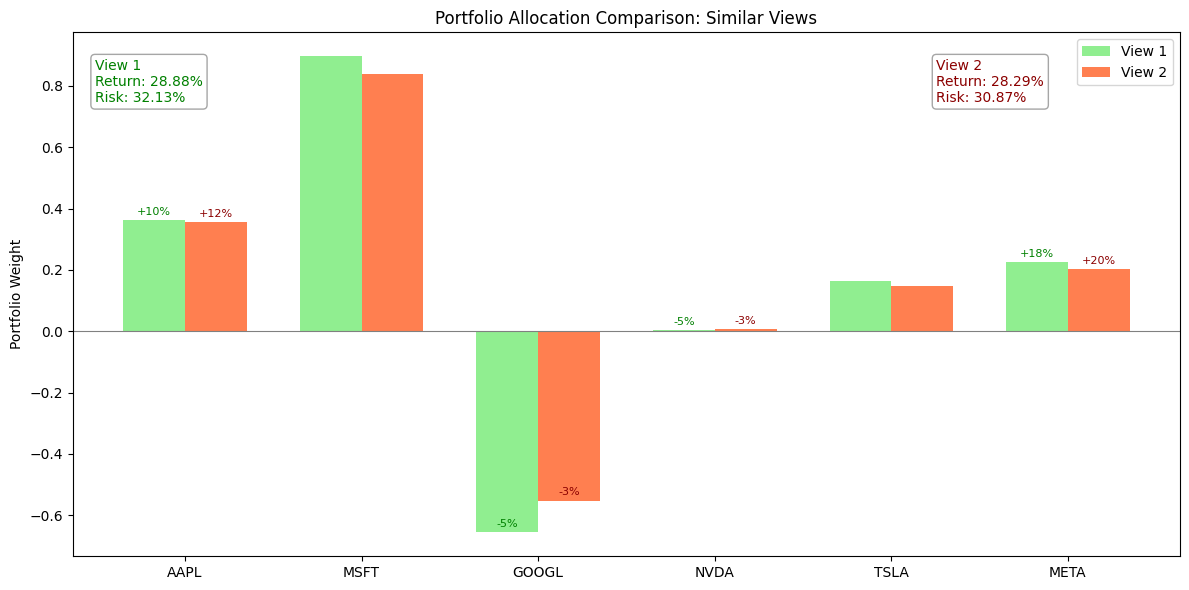

In [10]:
x = np.arange(len(tickers))
width = 0.35

# Black-Litterman portfolio weights for similar views
weights1 = np.array(w_bl_new)
weights2 = np.array(w_bl_new2)

# Views (expected excess returns)
views1 = {'AAPL': 0.10, 'GOOGL': -0.05, 'NVDA': -0.05, 'META': 0.18}
views2 = {'AAPL': 0.12, 'GOOGL': -0.03, 'NVDA': -0.03, 'META': 0.20}

# Compute expected return and risk for each views
expected_return1 = np.dot(weights1, r)
risk1 = np.sqrt(weights1.T @ cov @ weights1)

expected_return2 = np.dot(weights2, r)
risk2 = np.sqrt(weights2.T @ cov @ weights2)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, weights1, width, label='View 1', color='lightgreen')
bars2 = ax.bar(x + width/2, weights2, width, label='View 2', color='coral')

# Annotate views above bars
for i, ticker in enumerate(tickers):
    if ticker in views1:
        ax.text(x[i] - width/2, weights1[i] + 0.01,
                f'{views1[ticker]:+.0%}', ha='center', va='bottom', fontsize=8, color='green')
    if ticker in views2:
        ax.text(x[i] + width/2, weights2[i] + 0.01,
                f'{views2[ticker]:+.0%}', ha='center', va='bottom', fontsize=8, color='darkred')

# Annotate expected return and risk in corners
box_style = dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='gray')
ax.text(0.02, 0.95, f"View 1\nReturn: {expected_return1:.2%}\nRisk: {risk1:.2%}",
        transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=box_style, color='green')

ax.text(0.78, 0.95, f"View 2\nReturn: {expected_return2:.2%}\nRisk: {risk2:.2%}",
        transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=box_style, color='darkred')

# Labels and styling
ax.set_ylabel('Portfolio Weight')
ax.set_title('Portfolio Allocation Comparison: Similar Views')
ax.set_xticks(x)
ax.set_xticklabels(tickers)
ax.legend()
ax.axhline(0, color='gray', linewidth=0.8)
plt.tight_layout()
plt.show()

### Key Takeaways:

- Portfolio allocations are highly similar – changes are minor across assets.

- Both portfolios are very similar in structure, reflecting only minor deviations in asset weights, e.g., MSFT remains dominant in both, with slightly higher allocation in View 1.

- Return and risk metrics differ slightly, suggesting model stability.

- The portfolio shows moderate sensitivity to input changes – a desirable trait.



### Tangency Portfolio vs. Black-Litterman with Zero Views

In this section, we compare the classical **tangency portfolio** with a **Black-Litterman (BL) model under a neutral (zero-view) scenario**. The goal is to highlight how the BL framework adjusts portfolio allocations when no subjective views are provided, effectively blending equilibrium market weights with implied returns. This serves to demonstrate how the BL model inherently regularizes extreme portfolio positions and reduces sensitivity to estimation errors.

In [11]:
P_zero = np.eye(len(r))       # Each asset has its own "view", neutral
Q_zero = pi.copy()            # Views = implied returns from the market

# Omega under neutral views (relatively low uncertainty)
omega_zero = np.diag(np.diag(P_zero @ (tau * cov) @ P_zero.T))

# Compute Black-Litterman without views
tau_cov_inv = np.linalg.inv(tau * cov)
omega_inv = np.linalg.inv(omega_zero)
middle = np.linalg.inv(tau_cov_inv + P_zero.T @ omega_inv @ P_zero)
mu_bl_zero = middle @ (tau_cov_inv @ pi + P_zero.T @ omega_inv @ Q_zero)

# Black-Litterman portfolio weights (without views)
w_bl_zero = np.linalg.inv(lmbda * cov) @ mu_bl_zero
w_bl_zero /= np.sum(w_bl_zero)

bl_zero_weights = pd.Series(w_bl_zero, index=tickers)
bl_zero_weights


AAPL     0.261980
MSFT     0.259981
GOOGL    0.077191
NVDA     0.223924
TSLA     0.074295
META     0.102630
dtype: float64

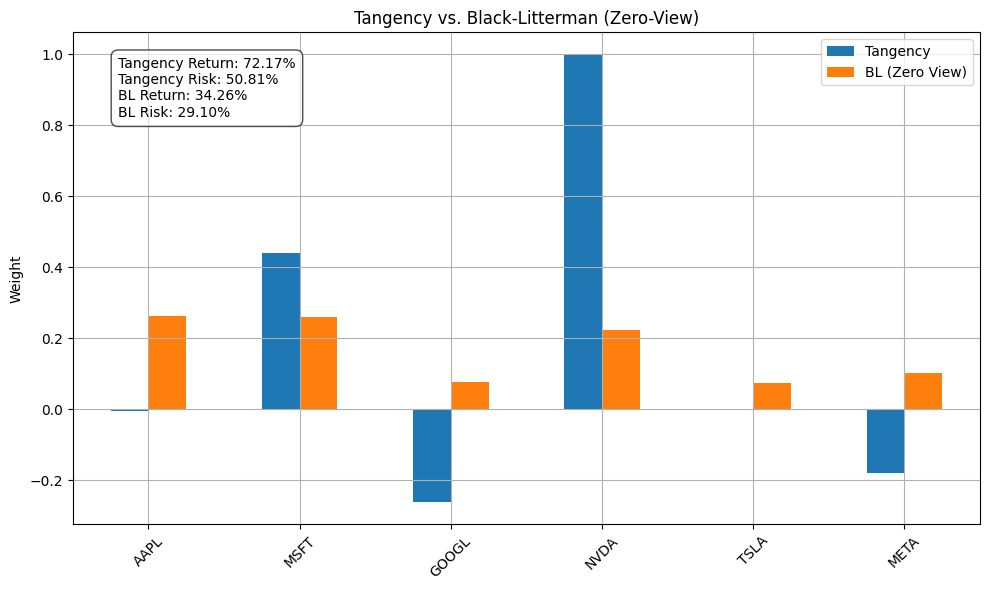

In [12]:
tangency = g/b 
tangency_portfolio_return = c/b
tangency_portfolio_risk = c**(1/2)/b

bl_return = np.dot(w_bl_zero, r)
bl_risk = np.sqrt(np.dot(w_bl_zero.T, np.dot(cov, w_bl_zero)))

# Compare weights
tangency_weights = tangency / np.sum(tangency)

compare_df = pd.DataFrame({
    'Tangency': tangency_weights,
    'BL (Zero View)': w_bl_zero
}, index=tickers)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
compare_df.plot(kind='bar', ax=ax)
ax.set_ylabel('Weight')
ax.set_title('Tangency vs. Black-Litterman (Zero-View)')
ax.set_xticklabels(tickers, rotation=45)
ax.grid(True)
plt.tight_layout()

# Add annotations with portfolio metrics
textstr = '\n'.join((
    f"Tangency Return: {tangency_portfolio_return:.2%}",
    f"Tangency Risk: {tangency_portfolio_risk:.2%}",
    f"BL Return: {bl_return:.2%}",
    f"BL Risk: {bl_risk:.2%}"
))

# Box with metrics in the top-right corner
props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='left', bbox=props)

plt.show()


### Interpretation of the Chart

The tangency portfolio, based purely on mean-variance optimization, produces highly concentrated allocations and exhibits extreme weights — a typical sign of overfitting due to the use of estimated returns and covariances. This is reflected in its very high expected return (72.17%) but also extremely high risk (50.81%).

In contrast, the Black-Litterman model with zero views results in a **more diversified and conservative portfolio**, smoothing out extreme exposures. This is achieved by combining the investor's lack of views with the equilibrium market weights (from the CAPM prior), leading to more stable and intuitive allocations. The outcome is a lower expected return (34.26%) but significantly reduced risk (29.10%), illustrating the **risk-reducing effect** of the BL framework in absence of strong conviction.

This comparison showcases how Black-Litterman acts as a **regularization mechanism** for portfolio optimization — taming the instability of the tangency solution without requiring strong subjective inputs.

Notably, in the absence of active views, the BL model tends to **default to market-capitalization-weighted portfolios**, or allocations very close to them. This is a direct consequence of its Bayesian foundation, where the prior (market equilibrium) dominates in the absence of strong investor input. This pattern can also be observed in the table below.


In [13]:
df_weights = pd.DataFrame({
    'Asset': tickers,
    'w_bl_zero': w_bl_zero,
    'w_mkt': w_mkt
})
df_weights

,Asset,w_bl_zero,w_mkt
0,AAPL,0.261980,0.261980
1,MSFT,0.259981,0.259981
2,GOOGL,0.077191,0.077191
3,NVDA,0.223924,0.223924
4,TSLA,0.074295,0.074295
5,META,0.102630,0.102630
